In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [34]:
def plot_series(time, series, format="-", start=0, end=None):

    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    plt.show()



In [35]:
def trend(time, slope=0):
    series = slope * time
    return series


In [36]:
def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


In [37]:
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


In [38]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level

    return noise


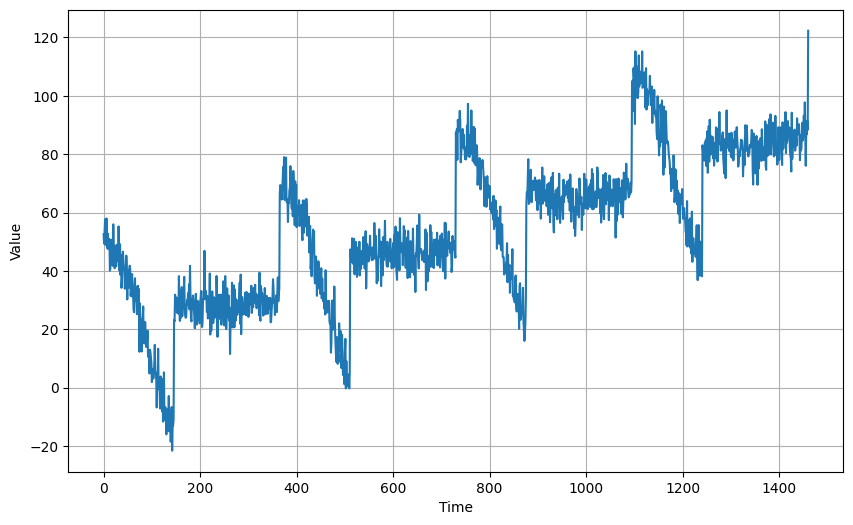

In [39]:

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

plot_series(time, series)


In [40]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


In [41]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [42]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [43]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [44]:
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')


shape of feature: (32, 20)
shape of label: (32,)


input of RNN = 3 dimenational tensor: (batchsizes, timesteps, features)

In [46]:
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


In [45]:
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [47]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 3s 35ms/step - loss: 64.6511 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 2s 66ms/step - loss: 58.4760 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 41ms/step - loss: 51.0776 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 38ms/step - loss: 43.4398 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 35ms/step - loss: 35.8121 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 36ms/step - loss: 28.3452 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 38ms/step - loss: 21.0639 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 37ms/step - loss: 14.4354 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 37ms/step - loss: 10.0459 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 38ms/step - loss: 8.3826 - lr: 2.8184e-08
Epoch 11/1

(1e-08, 0.001, 0.0, 50.0)

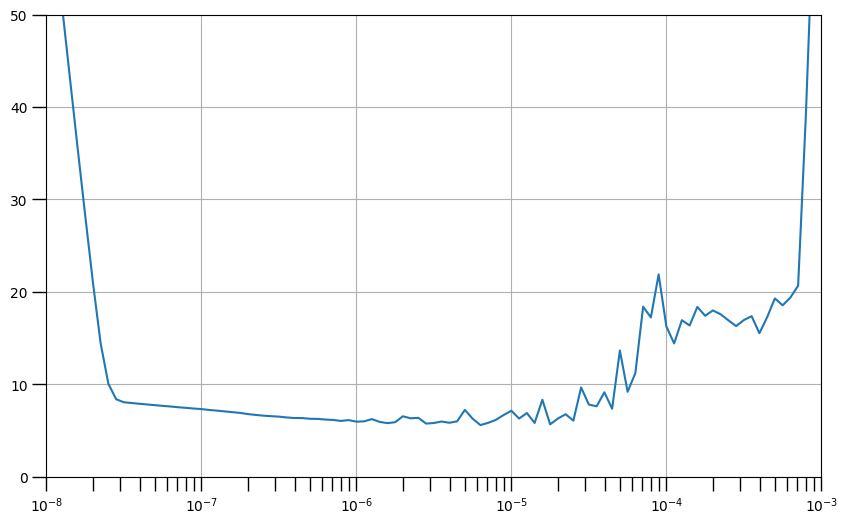

In [48]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 50])


In [49]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=100)


Epoch 1/100
31/31 [==============================] - 3s 35ms/step - loss: 21.1925 - mae: 21.6850
Epoch 2/100
31/31 [==============================] - 2s 72ms/step - loss: 10.2162 - mae: 10.7031
Epoch 3/100
31/31 [==============================] - 1s 36ms/step - loss: 9.3067 - mae: 9.7820
Epoch 4/100
31/31 [==============================] - 1s 37ms/step - loss: 8.5404 - mae: 9.0213
Epoch 5/100
31/31 [==============================] - 1s 37ms/step - loss: 8.5773 - mae: 9.0615
Epoch 6/100
31/31 [==============================] - 1s 36ms/step - loss: 8.1621 - mae: 8.6459
Epoch 7/100
31/31 [==============================] - 1s 35ms/step - loss: 8.0709 - mae: 8.5519
Epoch 8/100
31/31 [==============================] - 1s 36ms/step - loss: 8.0627 - mae: 8.5460
Epoch 9/100
31/31 [==============================] - 1s 36ms/step - loss: 8.0356 - mae: 8.5188
Epoch 10/100
31/31 [==============================] - 1s 37ms/step - loss: 7.9889 - mae: 8.4729
Epoch 11/100
31/31 [=========================

1/1 [==============================] - 0s 20ms/step


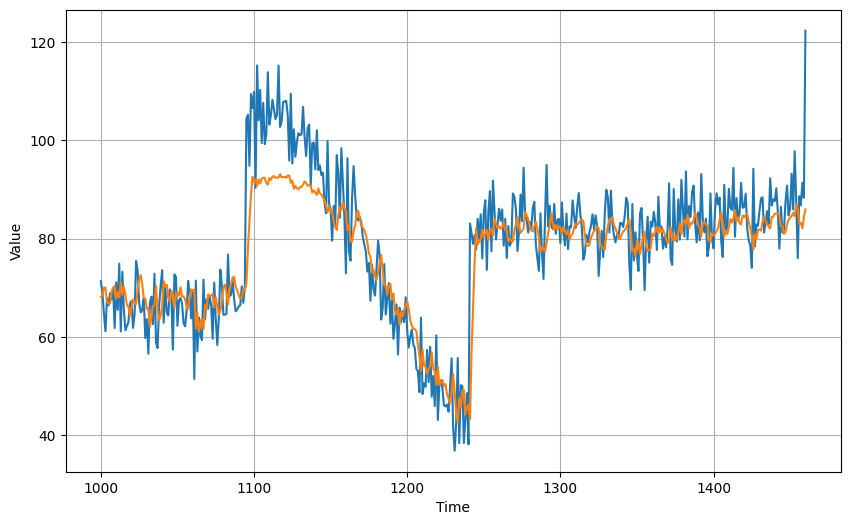

In [50]:
forecast = []

forecast_series = series[split_time - window_size:]
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))
results = np.array(forecast).squeeze()
plot_series(time_valid, (x_valid, results))


In [51]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)
    return forecast


15/15 [==============================] - 0s 10ms/step


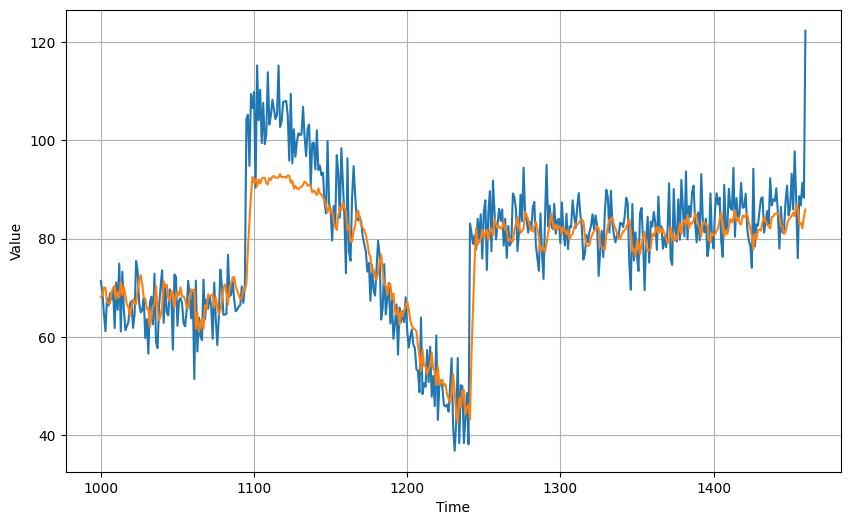

In [52]:
forecast_series = series[split_time - window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_valid, (x_valid, results))



In [53]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


58.135708
5.6114817
